# Pre-Processing Methods

For correcting exposure inconsistencies within an image, and performing effective smooothing. 

## Steps:
1. Import list of images
2. Determine settings for bilateral filter (edge-preserving)
3. Find a common correction
4. Loop through images

## Step 1: Import list of images

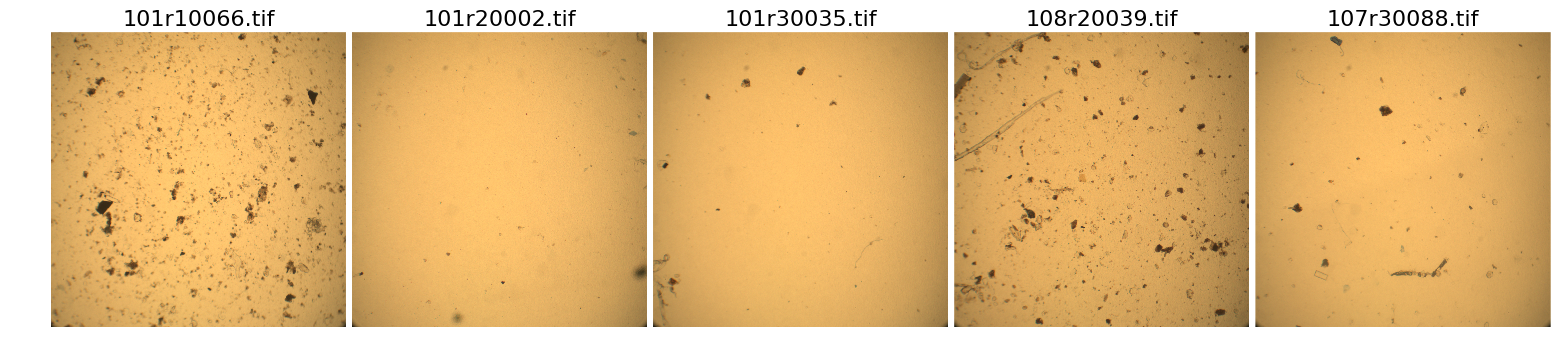

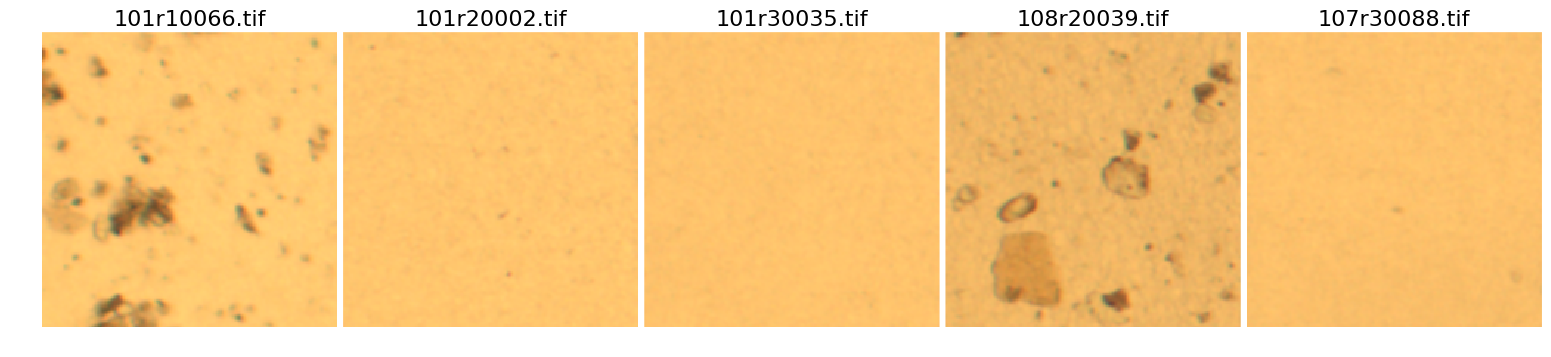

In [2]:
%matplotlib inline

#########################################################################################
dir_in = "/home/patrick/Documents/Jan25_HLD_Test/"
file_in = ["101r10066.tif", "101r20002.tif", "101r30035.tif", "108r20039.tif", "107r30088.tif"]
zoom = {'xmin' : 700,
        'xmax' : 900,
        'ymin' : 700,
        'ymax' : 900}
#########################################################################################

from matplotlib import pyplot as plt
from skimage import io, color, filters, draw, morphology, exposure, img_as_ubyte, img_as_float, restoration, measure
import pyroots as pr
import numpy as np
from scipy import ndimage
import cv2
from multiprocessing import Pool  
from multiprocessing.dummy import Pool as ThreadPool
import os

img_list = [io.imread(dir_in + i) for i in file_in]
pr.multi_image_plot(img_list, file_in)
pr.multi_image_plot([pr._zoom(i, **zoom) for i in img_list], file_in)

## Step 2: Settings for Bilateral Filter

In [3]:
########################################################################################
bilateral_args = {'sigmaColor' : 25,  # size of gaussian filter (higher smooths more, increases processing)
                  'sigmaSpace' : 15}  # Max difference of influence (higher preserves fewer edges)

test_image = [0, 1, 2, 3, 4]  # what images do you want to run this on? int or list
#########################################################################################

# bilat = [cv2.bilateralFilter(img_list[i], -1, **bilateral_args) for i in test_image]

img = bilat
pr.multi_image_plot(img, [file_in[i] for i in test_image])
pr.multi_image_plot([pr._zoom(i, **zoom) for i in img], file_in)

NameError: name 'bilat' is not defined

## Step 3: Common correction

In [4]:
#########################################################################################
exposure_args = {'smooth_iterations' : 3,     # times to run pyroots.equalize_exposure (mean filter, smoothed, as correction)
                 'return_variance'   : True,  # variance of mean correction for each pixel? For diagnostics.
                 'threads'           : 3}     # multiprocessing
#########################################################################################

# s-l-o-w function
calc = False
if calc is True:
    correction, variance = pr.calc_exposure_correction(bilat,
                                                       **exposure_args)

percentiles = [0, 0.5, 2.5, 5, 10, 25, 50, 75, 90, 95, 97.5, 99.5, 100]
print('Mean Percentiles: ')
print([np.percentile(correction, i) for i in percentiles])
print('\nVariation in Mean, percentiles:')
print([np.percentile(variance, i) for i in percentiles])

img = [correction, variance]
pr.multi_image_plot(img, ['mean', 'variance'])
pr.multi_image_plot([pr._zoom(i, **zoom) for i in img], file_in)

## Step 3: Loop Through Images

In [5]:
from time import time

def preprocessing_loop(base_directory, image_extension, correction_image, bilateral_args, threads=1,
               out_dir="Pyroots_Preprocessed", save_images=False):

    #Make an output directory for the analyzed images and data.
    if save_images is True:
        if not os.path.exists(base_directory + out_dir):
            os.mkdir(base_directory + out_dir)  
            
    for subdir, dirs, files in os.walk(base_directory):
        def _core_fn(file_in):
            if file_in.endswith(image_extension) and not subdir.endswith(out_dir):
                path_in = subdir + os.sep + file_in
                
                img = io.imread(path_in)  # load
                
                img = cv2.bilateralFilter(img, -1, **bilateral_args)  # bilateral filter
                
                img = img_as_float(img) + img_as_float(correction_image)  # correct exposure
                img[img>1] = 1
                img[img<0] = 0

                if save_images is True:
                    path_out = base_directory + out_dir + os.sep + subdir[len(base_directory)-1:] + file_in
                    io.imsave(path_out, img_as_ubyte(img) ) # save
                
                
                print("Done: " + subdir[len(base_directory):] + file_in)
                return(file_in)
            
        # init workers
        # cv2 already uses multicore processing, but loading and saving images also uses lots of resources
        # and should be parallelized
        thread_pool = ThreadPool(threads)
        
        # do it
        out = thread_pool.map(_core_fn, files)
        
        # close
        thread_pool.close()
        thread_pool.join()
        
        return(out)

### Save the correction for future reference

In [6]:
# io.imsave(dir_in + "Exposure Correction.tif", img_as_ubyte(correction))
correction = io.imread(dir_in + "Exposure Correction.tif")

In [7]:
calc = True
if calc is True:  # S-L-O-W
    x = preprocessing_loop(dir_in, 
                           ".tif", 
                           correction, 
                           bilateral_args, 
                           save_images=True, threads=4)

/home/patrick/Programs/scikit-image/skimage/util/dtype.py:118: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


Done: 108r10053.tif
Done: 107r20013.tif
Done: 101r10044.tif
Done: 108r30061.tif
Done: 101r10024.tif
Done: 101r20003.tif
Done: 107r30109.tif
Done: 108r10032.tif
Done: 101r10097.tif
Done: 101r30046.tif
Done: 101r10079.tif
Done: 101r10096.tif
Done: 101r10100.tif
Done: 101r30062.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r30077.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r30077.tif
Done: 108r20001.tif
Done: 101r10101.tif
Done: 107r10024.tif
Done: 101r30087.tif
Done: 107r30062.tif
Done: 107r20046.tif
Done: 108r20020.tif
Done: 101r30031.tif
Done: 101r30012.tif
Done: 101r20004.tif
Done: 101r20079.tif
Done: 107r30073.tif
Done: 101r30018.tif
Done: 108r20056.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//108r30001.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 108r30001.tif
Done: 101r20007.tif
Done: 101r10104.tif
Done: 101r10067.tif
Done: 107r30103.tif
Done: Exposure Correction.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r20091.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r20091.tif
Done: 101r30039.tif
Done: 108r20023.tif
Done: 101r20030.tif
Done: 108r10044.tif
Done: 108r30026.tif
Done: 101r10034.tif
Done: 108r20064.tif
Done: 101r10091.tif
Done: 108r30017.tif
Done: 101r30050.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r20100.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r20100.tif
Done: 101r30083.tif
Done: 108r20002.tif
Done: 101r20059.tif
Done: 107r30099.tif
Done: 101r30010.tif
Done: 108r10047.tif
Done: 101r10088.tif
Done: 108r20008.tif
Done: 107r20058.tif
Done: 107r20010.tif
Done: 108r10012.tif
Done: 108r20037.tif
Done: 108r20051.tif
Done: 108r20010.tif
Done: 101r10068.tif
Done: 107r30090.tif
Done: 107r30100.tif
Done: 101r10077.tif
Done: 101r10041.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r20087.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r20087.tif
Done: 107r10059.tif
Done: 107r10013.tif
Done: 101r10022.tif
Done: 108r30068.tif
Done: 107r20012.tif
Done: 108r20007.tif
Done: 101r10046.tif
Done: 101r10025.tif
Done: 101r10029.tif
Done: 108r10052.tif
Done: 101r10094.tif
Done: 101r10105.tif
Done: 101r30024.tif
Done: 101r20050.tif
Done: 101r20039.tif
Done: 107r30119.tif
Done: 108r20021.tif
Done: 107r30072.tif
Done: 107r30094.tif
Done: 108r10001.tif
Done: 107r20048.tif
Done: 107r10028.tif
Done: 101r30051.tif
Done: 101r10062.tif
Done: 101r10099.tif
Done: 108r30037.tif
Done: 101r10069.tif
Done: 107r30083.tif
Done: 101r20006.tif
Done: 101r10008.tif
Done: 101r30001.tif
Done: 108r30073.tif
Done: 107r30075.tif
Done: 108r20053.tif
Done: 101r20096.tif
Done: 101r10012.tif
Done: 107r20043.tif
Done: 101r10052.tif
Done: 108r30007.tif
Done: 108r30062.tif
Done: 108r10030.tif
Done: 108r20014.tif
Done: 101r30008.tif
Done: 101r30015.tif
Done: 107r20033.tif
Done: 108r20057.tif
Done: 108r10004.tif
Done: 101r10023.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r30072.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r30072.tif
Done: 107r30087.tif
Done: 101r30074.tif
Done: 101r10124.tif
Done: 107r30084.tif
Done: 108r20026.tif
Done: 101r30017.tif
Done: 108r30050.tif
Done: 107r30097.tif
Done: 101r20047.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r30047.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r30047.tif
Done: 107r30076.tif
Done: 101r30085.tif
Done: 108r30029.tif
Done: 107r30065.tif
Done: 101r30041.tif
Done: 107r10031.tif
Done: 107r30107.tif
Done: 101r20089.tif
Done: 107r30091.tif
Done: 101r10031.tif
Done: 108r10013.tif
Done: 108r10011.tif
Done: 107r20057.tif
Done: 107r20017.tif
Done: 101r20115.tif
Done: 101r20109.tif
Done: 107r10010.tif
Done: 108r20059.tif
Done: 108r30003.tif
Done: 108r20062.tif
Done: 107r10053.tif
Done: 101r10112.tif
Done: 107r10052.tif
Done: 101r10009.tif
Done: 101r20002.tif
Done: 101r30082.tif
Done: 101r10086.tif
Done: 101r10007.tif
Done: 108r30011.tif
Done: 101r10010.tif
Done: 108r20004.tif
Done: 107r30092.tif
Done: 108r10051.tif
Done: 101r10021.tif
Done: 107r20035.tif
Done: 108r30045.tif
Done: 101r20056.tif
Done: 108r10010.tif
Done: 108r10006.tif
Done: 108r10016.tif
Done: 108r20041.tif
Done: 101r30011.tif
Done: 107r20003.tif
Done: 108r30020.tif
Done: 101r10092.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r20094.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r20094.tif
Done: 101r10122.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r20040.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r20040.tif
Done: 101r30013.tif
Done: 107r20056.tif
Done: 101r20105.tif
Done: 108r30064.tif
Done: 108r30032.tif
Done: 108r10048.tif
Done: 101r30022.tif
Done: 101r10085.tif
Done: 101r30058.tif
Done: 108r30028.tif
Done: 101r10016.tif
Done: 101r20099.tif
Done: 108r30053.tif
Done: 107r30112.tif
Done: 101r20034.tif
Done: 108r30052.tif
Done: 108r30006.tif
Done: 101r20057.tif
Done: 107r20014.tif
Done: 107r30120.tif
Done: 107r20040.tif
Done: 101r20108.tif
Done: 101r30070.tif
Done: 101r20107.tif
Done: 108r10029.tif
Done: 101r30035.tif
Done: 101r10060.tif
Done: 107r30086.tif
Done: 107r30082.tif
Done: 108r30041.tif
Done: 107r20053.tif
Done: 107r10055.tif
Done: 101r20020.tif
Done: 101r10120.tif
Done: 101r10005.tif
Done: 101r20041.tif
Done: 101r20055.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r20068.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r20068.tif
Done: 101r10107.tif
Done: 107r30078.tif
Done: 107r10048.tif
Done: 108r20045.tif
Done: 101r30028.tif
Done: 101r10056.tif
Done: 101r10040.tif
Done: 101r20023.tif
Done: 101r20102.tif
Done: 101r10032.tif
Done: 101r10066.tif
Done: 101r30021.tif
Done: 108r10050.tif
Done: 101r30076.tif
Done: 101r20024.tif
Done: 108r20028.tif
Done: 107r30088.tif
Done: 108r20035.tif
Done: 107r10004.tif
Done: 101r10063.tif
Done: 101r20062.tif
Done: 101r10111.tif
Done: 101r10090.tif
Done: 107r10043.tif
Done: 101r20098.tif
Done: 101r30034.tif
Done: 107r10008.tif
Done: 101r30009.tif
Done: 101r10117.tif
Done: 108r20022.tif
Done: 101r20110.tif
Done: 107r10030.tif
Done: 108r20047.tif
Done: 107r20023.tif
Done: 101r10093.tif
Done: 108r30023.tif
Done: 108r20029.tif
Done: 108r20052.tif
Done: 108r10014.tif
Done: 108r30034.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r30065.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r30065.tif
Done: 101r10076.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r20113.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r20113.tif
Done: 107r10029.tif
Done: 107r20011.tif
Done: 108r20048.tif
Done: 107r20054.tif
Done: 107r30108.tif
Done: 101r10121.tif
Done: 108r10056.tif
Done: 101r20036.tif
Done: 108r30056.tif
Done: 108r30071.tif
Done: 101r10072.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r20097.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r20097.tif
Done: 101r20028.tif
Done: 108r30005.tif
Done: 107r30081.tif
Done: 107r20029.tif
Done: 107r30060.tif
Done: 108r20027.tif
Done: 107r30110.tif
Done: 107r20015.tif
Done: 101r20008.tif
Done: 107r20044.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//107r10062.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 107r10062.tif
Done: 101r30081.tif
Done: 101r10061.tif
Done: 101r30049.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//108r10005.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 108r10005.tif
Done: 107r10034.tif
Done: 101r20114.tif
Done: 101r20045.tif
Done: 101r10065.tif
Done: 108r10035.tif
Done: 107r30077.tif
Done: 108r10031.tif
Done: 101r10108.tif
Done: 101r20015.tif
Done: 107r30098.tif
Done: 101r30048.tif
Done: 108r20038.tif
Done: 101r30063.tif
Done: 101r10070.tif
Done: 108r20065.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//107r20022.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 107r20022.tif
Done: 101r20066.tif
Done: 107r20026.tif
Done: 108r10046.tif
Done: 101r20013.tif
Done: 107r10019.tif
Done: 108r30058.tif
Done: 101r10059.tif
Done: 107r30067.tif
Done: 101r20076.tif
Done: 108r10026.tif
Done: 101r20012.tif
Done: 107r10040.tif
Done: 108r30024.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r20086.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r20086.tif
Done: 101r10089.tif
Done: 107r30080.tif
Done: 101r30043.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//107r10026.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 107r10026.tif
Done: 108r10042.tif
Done: 107r30114.tif
Done: 101r10028.tif
Done: 108r20046.tif
Done: 101r30033.tif
Done: 108r10040.tif
Done: 101r30066.tif
Done: 108r20061.tif
Done: 101r10087.tif
Done: 107r10045.tif
Done: 108r30009.tif
Done: 107r20052.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r20088.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r20088.tif
Done: 108r20034.tif
Done: 101r10043.tif
Done: 108r10009.tif
Done: 107r10044.tif
Done: 107r10015.tif
Done: 108r30025.tif
Done: 107r20005.tif
Done: 101r30068.tif
Done: 101r20044.tif
Done: 107r20036.tif
Done: 108r20060.tif
Done: 101r20061.tif
Done: 101r10080.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r20101.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r20101.tif
Done: 101r20032.tif
Done: 101r20029.tif
Done: 108r30072.tif
Done: 107r20047.tif
Done: 101r10073.tif
Done: 101r20016.tif
Done: 101r10102.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r20082.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r20082.tif
Done: 101r30036.tif
Done: 108r20058.tif
Done: 101r30078.tif
Done: 108r30010.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r30002.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r30002.tif
Done: 101r10119.tif
Done: 101r10123.tif
Done: 107r30096.tif
Done: 108r30060.tif
Done: 101r30007.tif
Done: 108r30014.tif
Done: 101r10039.tif
Done: 101r30059.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r30084.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r30084.tif
Done: 107r10049.tif
Done: 101r10053.tif
Done: 107r30085.tif
Done: 101r10030.tif
Done: 101r20026.tif
Done: 101r20051.tif
Done: 107r20030.tif
Done: 101r10116.tif
Done: 108r30044.tif
Done: 101r20031.tif
Done: 107r30106.tif
Done: 107r20051.tif
Done: 101r10106.tif
Done: 108r30015.tif
Done: 101r30016.tif
Done: 101r10109.tif
Done: 101r20106.tif
Done: 101r20011.tif
Done: 108r20063.tif
Done: 108r30018.tif
Done: 101r20027.tif
Done: 107r20009.tif
Done: 107r30093.tif
Done: 101r10075.tif
Done: 108r10033.tif
Done: 108r30074.tif
Done: 108r10027.tif
Done: 101r20070.tif
Done: 107r10039.tif
Done: 108r20025.tif
Done: 108r30021.tif
Done: 101r20001.tif
Done: 101r10095.tif
Done: 108r30043.tif
Done: 108r20067.tif
Done: 107r20001.tif
Done: 108r10025.tif
Done: 108r30046.tif
Done: 108r30036.tif
Done: 101r20071.tif
Done: 107r10025.tif
Done: 107r10054.tif
Done: 107r10051.tif
Done: 108r20032.tif
Done: 101r20083.tif
Done: 107r10038.tif
Done: 101r20116.tif
Done: 101r10017.tif
Done: 108r30070.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r20054.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r20067.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r20067.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r20093.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r20093.tif
Done: 101r30080.tif
Done: 101r10002.tif
Done: 108r30008.tif
Done: 101r30055.tif
Done: 101r30061.tif
Done: 101r20022.tif
Done: 101r20095.tif
Done: 101r20019.tif
Done: 101r20117.tif
Done: 108r30051.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r20010.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r20010.tif
Done: 101r30052.tif
Done: 107r10042.tif
Done: 101r20069.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r20063.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r20063.tif
Done: 101r10055.tif
Done: 101r20078.tif
Done: 107r20039.tif
Done: 101r10033.tif
Done: 108r10020.tif
Done: 107r20019.tif
Done: 107r30117.tif
Done: 101r10064.tif
Done: 108r10003.tif
Done: 107r10041.tif
Done: 101r10001.tif
Done: 108r30027.tif
Done: 108r30040.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r20084.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r20084.tif
Done: 107r20050.tif
Done: 107r30064.tif
Done: 101r10051.tif
Done: 108r30035.tif
Done: 107r30111.tif
Done: 108r20030.tif
Done: 101r10114.tif
Done: 101r30079.tif
Done: 108r30030.tif
Done: 101r30038.tif
Done: 108r30016.tif
Done: 107r10009.tif
Done: 108r10038.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r30069.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r30069.tif
Done: 101r10047.tif
Done: 101r20077.tif
Done: 108r20005.tif
Done: 101r20058.tif
Done: 101r20049.tif
Done: 108r20016.tif
Done: 101r20064.tif
Done: 101r20005.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r30064.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r30064.tif
Done: 108r20015.tif
Done: 107r30101.tif
Done: 101r30044.tif
Done: 108r20012.tif
Done: 108r30038.tif
Done: 101r10020.tif
Done: 101r20085.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r20081.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r20081.tif
Done: 108r20036.tif
Done: 101r20090.tif
Done: 107r10007.tif
Done: 108r20050.tif
Done: 108r20031.tif
Done: 107r30066.tif
Done: 108r20011.tif
Done: 108r30047.tif
Done: 107r20025.tif
Done: 108r10054.tif
Done: 108r30049.tif
Done: 108r10036.tif
Done: 108r10028.tif
Done: 101r20021.tif
Done: 101r10048.tif
Done: 107r30063.tif
Done: 101r30045.tif
Done: 108r20019.tif
Done: 107r10014.tif
Done: 107r20024.tif
Done: 101r30027.tif
Done: 107r10035.tif
Done: 108r20009.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r20073.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r20073.tif
Done: 107r20032.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//108r30054.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 108r30054.tif
Done: 101r30014.tif
Done: 107r20041.tif
Done: 101r10074.tif
Done: 101r10026.tif
Done: 101r30025.tif
Done: 101r10115.tif
Done: 101r10113.tif
Done: 107r20037.tif
Done: 101r10071.tif
Done: 108r20039.tif
Done: 101r30056.tif
Done: 108r30004.tif
Done: 101r20046.tif
Done: 108r10019.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//107r10058.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 107r10058.tif
Done: 107r30104.tif
Done: 107r20042.tif
Done: 101r10110.tif
Done: 107r30071.tif
Done: 108r30065.tif
Done: 107r10046.tif
Done: 108r20055.tif
Done: 107r30118.tif
Done: 101r30040.tif
Done: 108r20042.tif
Done: 101r20072.tif
Done: 108r10007.tif
Done: 101r10004.tif
Done: 101r10118.tif
Done: 108r30002.tif
Done: 107r30069.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r20043.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 108r10037.tif
Done: 101r20043.tif
Done: 101r10035.tif
Done: 107r20027.tif
Done: 108r30042.tif
Done: 108r30033.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//107r20021.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 107r20021.tif
Done: 107r10032.tif
Done: 101r10042.tif
Done: 108r30012.tif
Done: 108r30013.tif
Done: 101r10083.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//107r20028.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 107r20028.tif
Done: 107r20016.tif
Done: 108r30063.tif
Done: 101r10036.tif
Done: 101r10006.tif
Done: 108r30067.tif
Done: 101r20033.tif
Done: 107r30079.tif
Done: 101r20118.tif
Done: 108r20006.tif
Done: 101r10038.tif
Done: 107r20002.tif
Done: 108r30019.tif
Done: 101r20053.tif
Done: 101r10011.tif
Done: 107r10036.tif
Done: 101r20037.tif
Done: 101r30029.tif
Done: 101r20017.tif
Done: 107r10021.tif
Done: 108r30057.tif
Done: 101r10037.tif
Done: 107r20018.tif
Done: 101r30075.tif
Done: 108r10041.tif
Done: 107r10006.tif
Done: 107r10050.tif
Done: 101r20014.tif
Done: 108r30055.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r20065.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r20065.tif
Done: 107r30113.tif
Done: 101r10078.tif
Done: 108r10021.tif
Done: 108r20024.tif
Done: 107r10005.tif
Done: 107r30115.tif
Done: 101r20025.tif
Done: 107r20007.tif
Done: 101r20060.tif
Done: 107r30116.tif
Done: 107r10018.tif
Done: 108r10034.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r20112.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r20112.tif
Done: 108r10055.tif
Done: 101r10058.tif
Done: 108r30039.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r30032.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r30032.tif
Done: 101r30020.tif
Done: 107r20038.tif
Done: 101r10098.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r20075.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r20075.tif
Done: 101r20119.tif
Done: 101r20018.tif
Done: 108r10022.tif
Done: 107r10002.tif
Done: 101r10018.tif
Done: 101r20042.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r20074.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r20074.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//107r10056.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 107r10056.tif
Done: 107r10060.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//107r10061.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 107r10061.tif
Done: 107r10027.tif
Done: 101r30019.tif
Done: 108r30031.tif
Done: 107r10016.tif
Done: 108r20043.tif
Done: 107r10011.tif
Done: 101r20104.tif
Done: 108r20033.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r20092.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r20092.tif
Done: 101r30004.tif
Done: 107r30102.tif
Done: 107r10003.tif
Done: 101r10045.tif
Done: 108r10017.tif
Done: 101r20111.tif
Done: 108r10008.tif
Done: 108r10015.tif
Done: 101r10019.tif
Done: 101r30026.tif
Done: 101r10014.tif
Done: 101r10027.tif
Done: 101r30023.tif
Done: 107r30061.tif
Done: 107r10057.tif
Done: 101r10003.tif
Done: 101r30006.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//107r20020.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 107r20020.tif
Done: 107r20034.tif
Done: 107r20055.tif
Done: 107r30095.tif
Done: 107r20006.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r30071.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r30071.tif
Done: 107r30074.tif
Done: 108r10039.tif
Done: 108r20049.tif
Done: 101r10084.tif
Done: 108r10049.tif
Done: 107r10023.tif
Done: 101r30037.tif
Done: 101r30053.tif
Done: 101r30042.tif
Done: 108r20066.tif
Done: 108r10023.tif
Done: 108r30066.tif
Done: 108r30048.tif
Done: 107r30070.tif
Done: 101r20048.tif
Done: 107r20004.tif
Done: 101r30086.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//107r10012.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 107r10012.tif
Done: 101r30067.tif
Done: 108r10043.tif
Done: 107r20049.tif
Done: 108r20017.tif
Done: 101r10054.tif
Done: 101r10057.tif
Done: 101r20052.tif
Done: 107r30105.tif
Done: 107r10047.tif


/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed//101r20080.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Done: 101r20080.tif
Done: 108r20013.tif
Done: 108r10002.tif
Done: 101r20038.tif
Done: 101r10081.tif
Done: 107r10033.tif
Done: 101r20009.tif
Done: 107r20031.tif
Done: 101r10103.tif
Done: 107r10020.tif
Done: 107r30089.tif
Done: 108r10045.tif
Done: 101r30003.tif
Done: 101r20035.tif
Done: 101r10015.tif
Done: 108r10018.tif
Done: 108r20054.tif
Done: 101r30060.tif
Done: 107r10037.tif
Done: 108r30022.tif
Done: 107r10022.tif
Done: 101r20103.tif
Done: 101r30005.tif
Done: 101r30054.tif
Done: 101r10013.tif
Done: 107r20008.tif
Done: 108r20040.tif
Done: 107r20059.tif
Done: 101r10049.tif


In [ ]:
x